In our research project, we seeked to analyze the structures and functions of governments among different countries through textual analysis of their constitution or governing laws. We hope to find correlation between aspects of each countries' constitution and their human freedom score. For example, we believe that constitutions that have higher emphasis on things like freedom of speech and freedom of press probably will have higher human freedom scores. 

The first part of our project will focus on scraping constitutions of the web. There is an initiative called the Constitute Project (https://www.constituteproject.org/?lang=en) that has collected constitutions from a plethora of nations throughout the globe. We will be using BeautifulSoup to automate this process so we do not have to copy and paste from each site individually. We will be scraping plain text of each constitution from the website. 

In [1]:
from bs4 import BeautifulSoup
import requests
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import string
import gensim
from gensim import corpora
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

We collect some important sets like punctiation and stopwords in order to limit the amount of text we scrape to only text we believe to be more important. We create a function "clean" to clean the scraped text. We have some hard coded methods to deal with situational cases, for example: Israel's name of its parliament. 

In [2]:
stop = set(stopwords.words('english'))
stop.add("section") #we dont care about the structural parts of the papers
stop.add("act")
stop.add("article")
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    doc = doc.replace('[blank]', '') #gets rid of html blanks that appear after scraping
    doc = doc.replace('shall', '')
    doc = doc.replace('may', '')
    doc = doc.replace('\n', '') #gets rid of spacing
    doc = doc.replace("Länder", "state") #Länder is the German state
    doc = doc.replace("Knesset", "parliament") #Israel's parliament name
    doc = doc.replace("Yang di-Pertuan Agong", "King") #Malaysia's Yang di-Pertuan Agong is the position of King
    doc = doc.replace("People’s", "Peoples") #DPRK's punctuation check doesn't work correctly. Have to hard code.
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop]) # gets rid of stop words
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude) #gets rid of punctuation 
    short_free = " ".join(word for word in punc_free.split() if len(word)>2) #gets rid of words under 3 characters long
    normalized = " ".join(lemma.lemmatize(word) for word in short_free.split()) 
    return normalized

We start with a list of links to each nation's constitutions. All of our methods from here on out are flexible to this list, thus adding countries is fairly easy. However these nations have to have a matching human freedom score from our csv we will load later. We create a few structures to hold the different ways we want to hold the text. We have a dictionary to hold the country's name as a key and the full plain text as its value. We also include a list of country names just so we can subsitute with it later. We have a list of just the plain text in order to run methods direct onto the entirety of the text without having to deal with messy country names and structure. We hard code some replacement names in order to match the name of the country to the ones in the csv that holds human freedom scores. 

In [3]:
countries = ["https://www.constituteproject.org/constitution/Canada_2011?lang=en",
             "https://www.constituteproject.org/constitution/China_2018?lang=en",
             "https://www.constituteproject.org/constitution/United_States_of_America_1992?lang=en",
             "https://www.constituteproject.org/constitution/United_Kingdom_2013?lang=en",
             "https://www.constituteproject.org/constitution/France_2008?lang=en",
             "https://www.constituteproject.org/constitution/Australia_1985?lang=en",
             "https://www.constituteproject.org/constitution/German_Federal_Republic_2014?lang=en",
             "https://www.constituteproject.org/constitution/Iran_1989?lang=en",
             "https://www.constituteproject.org/constitution/India_2016?lang=en",
             "https://www.constituteproject.org/constitution/Israel_2013?lang=en",
             "https://www.constituteproject.org/constitution/Italy_2012?lang=en",
             "https://www.constituteproject.org/constitution/Japan_1946?lang=en",
             "https://www.constituteproject.org/constitution/Republic_of_Korea_1987?lang=en",
             "https://www.constituteproject.org/constitution/Lebanon_2004?lang=en",
             "https://www.constituteproject.org/constitution/Malaysia_2007?lang=en",
             "https://www.constituteproject.org/constitution/Nigeria_2011?lang=en",
             "https://www.constituteproject.org/constitution/Russia_2014?lang=en",
             "https://www.constituteproject.org/constitution/Saudi_Arabia_2013?lang=en",
             "https://www.constituteproject.org/constitution/Spain_2011?lang=en",
             "https://www.constituteproject.org/constitution/Sudan_2019?lang=en",
             "https://www.constituteproject.org/constitution/Taiwan_2005?lang=en",
             "https://www.constituteproject.org/constitution/United_Arab_Emirates_2009?lang=en",
             "https://www.constituteproject.org/constitution/Venezuela_2009?lang=en",
             "https://www.constituteproject.org/constitution/Malaysia_2007?lang=en",
             "https://www.constituteproject.org/constitution/Brazil_2017?lang=en",
             "https://www.constituteproject.org/constitution/Argentina_1994?lang=en",
             "https://www.constituteproject.org/constitution/Chile_2015?lang=en",
             "https://www.constituteproject.org/constitution/Egypt_2019?lang=en",
             "https://www.constituteproject.org/constitution/Turkey_2017?lang=en",
             "https://www.constituteproject.org/constitution/Ethiopia_1994?lang=en",
             "https://www.constituteproject.org/constitution/Ghana_1996?lang=en"]

country_dic = dict()
country_list = []
complete_doc = []

for country in countries:
    page = requests.get(country)
    sp = BeautifulSoup(page.text, features="lxml")
    text = clean(sp.get_text())
    name = str(re.findall(r'n/.*l', country))
    x = name[4:-4]
    country_name = x.split("_")[0:-1]
    x = " ".join(country_name)
    if "German" in x:
        x = "Germany"
    if "Korea" in x:
        x = "Korea, South"
    if "United States of America" in x:
        x = "United States"
    country_dic[x] = text
    complete_doc.append(text)
    country_list.append(x)

We next want to read in the csv from the Cato Institute (https://www.cato.org/human-freedom-index-new). This stores rankings and scores for many countries around the world in each respective year. We first turn our country dictionary into a dataframe so we can later add the human freedom scores as a new column. We need a few lines to ensure we get the most recent human freedom score and attach it to the correct nation. 

In [4]:
country_df = pd.DataFrame(country_dic.items(), columns=['Country', 'Text'])
freedom_index = pd.read_csv("human-freedom-index-2019.csv")
freedom_dict = dict()
freedom_list = []
for country in country_dic:
    row = freedom_index[freedom_index["countries"] == country] #gets all rows of each country
    recent = row[row['year']==row['year'].max()] #gets most recent year
    x = recent['hf_score'].astype(float)
    freedom_dict[str(country)] = x.values
    freedom_list.append(freedom_dict[str(country)])

country_df["HF Score"] = freedom_list

The next step was to simply visualize the most common words in each plain text. This gives a good foundation of what to expect from each document. We used tokenizers to split the document into words and counted the top 5 most common words. We then used matplotlib to plot each as a bar graph of each term and its frequency. 

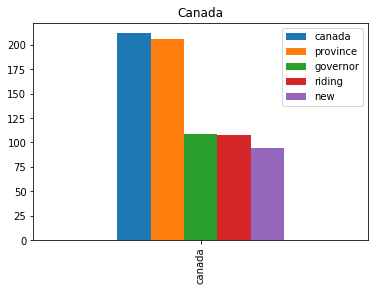

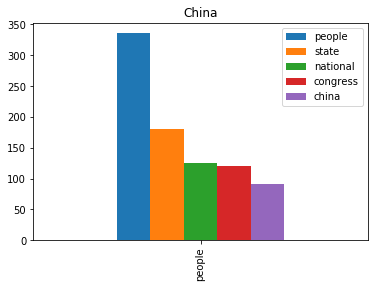

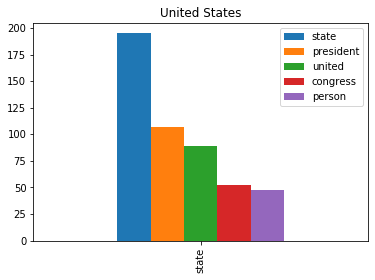

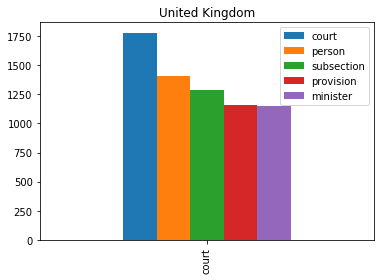

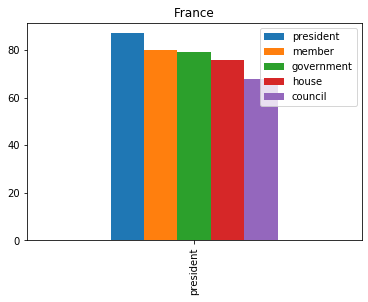

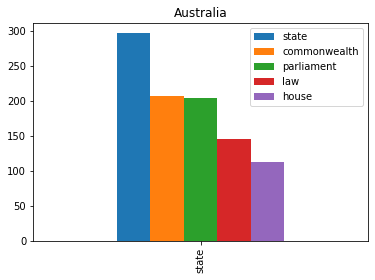

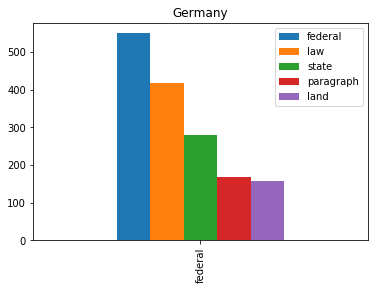

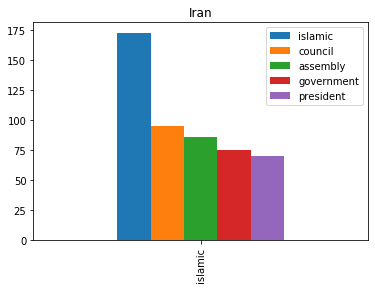

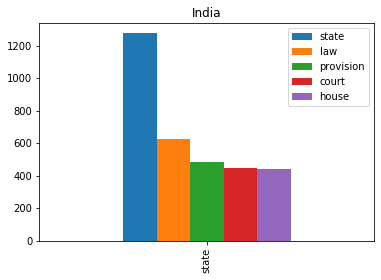

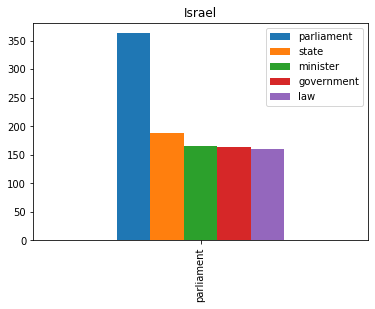

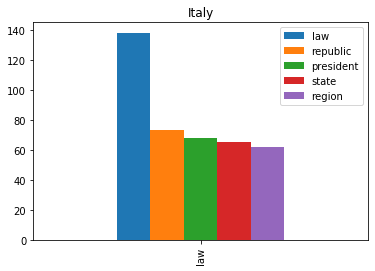

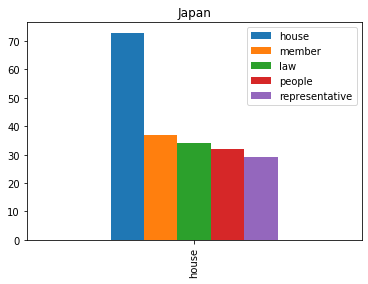

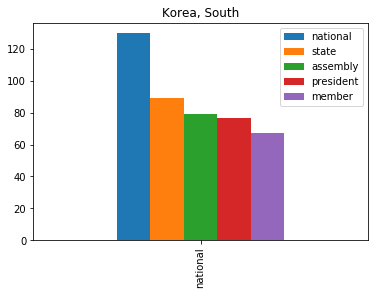

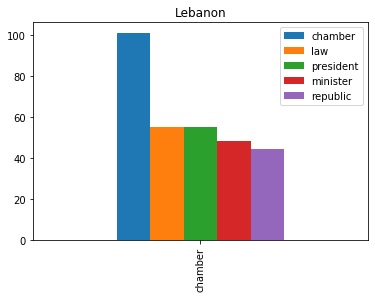

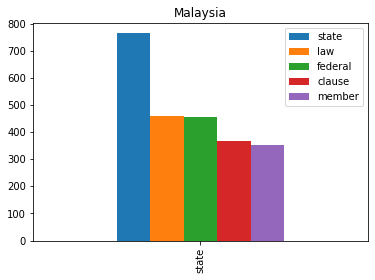

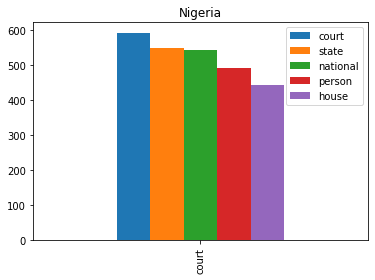

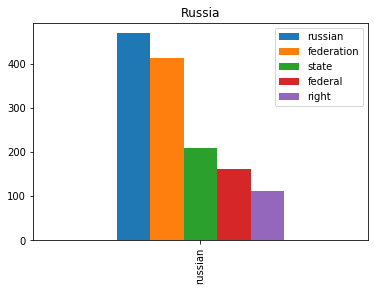

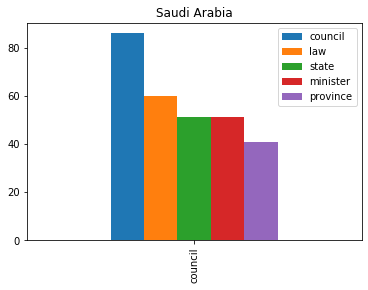

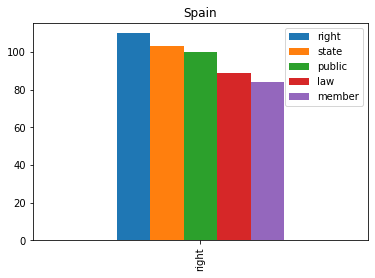

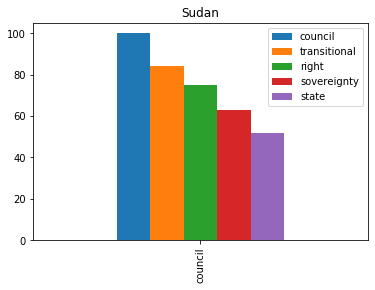

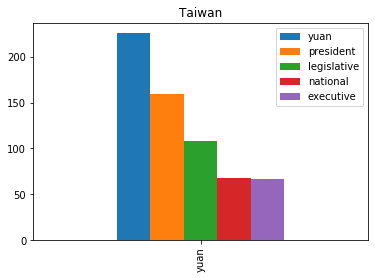

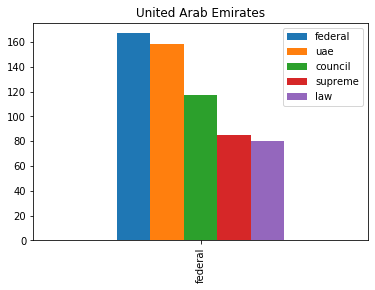

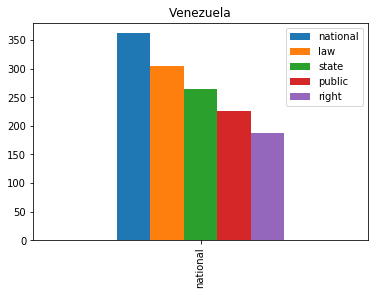

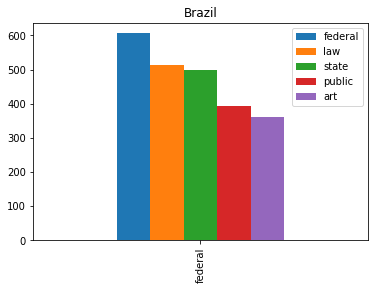

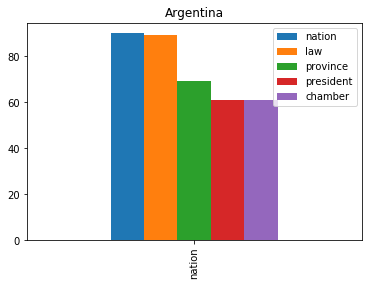

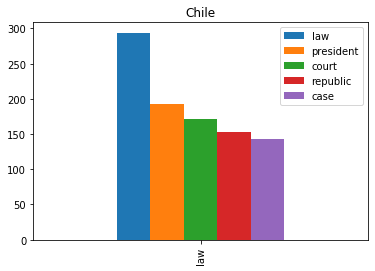

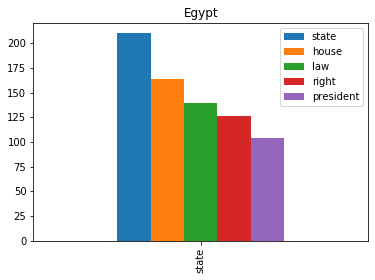

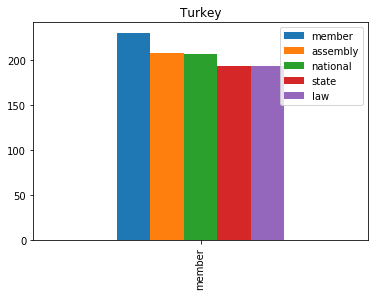

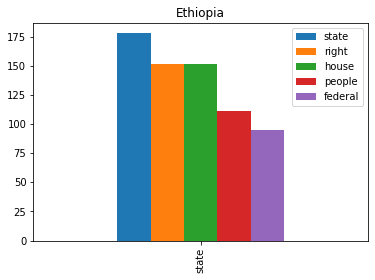

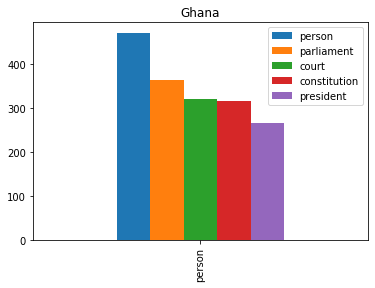

In [5]:
most_common = dict()
for key in country_dic:
    doc = country_dic[key]
    newdoc = clean(doc)
    tokenizer = RegexpTokenizer(r'\w+')
    tk = tokenizer.tokenize(newdoc)
    counts = Counter(tk)
    newcounts = dict(Counter(counts).most_common(5))
    k = newcounts.keys()
    df = pd.DataFrame(newcounts, index=k)
    df.drop(df.columns[1:], inplace=True)
    df.plot(title=key, kind='bar')
    plt.show()

We then use a LDA model to extract topics from the documents. We create 15 topics as we believed the human freedom score to be a pretty wide spectrum across different countries, thus we wanted to account for the marginal changes. We create a method called maxTopic to return the topic with the highest likelihood to gather the topic terms of each country. We save bind these countries to their topic terms and will use these terms later to attempt to predict human freedom scores. 

In [6]:
def maxTopic(listoftopics):
    cur_max = 0
    cur_topic = None
    for topic in listoftopics:
        if topic[1] > cur_max:
            cur_max = topic[1]
            cur_topic = topic[0]
    return cur_topic

In [7]:
doc_clean = [clean(doc).split() for doc in complete_doc]

dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

LDA = gensim.models.ldamodel.LdaModel
LDAmodel = LDA(doc_term_matrix, num_topics=15, id2word=dictionary, passes=50)
x = LDAmodel.show_topics(num_topics=15, num_words=5,formatted=False)
#for i in range(0, LDAmodel.num_topics):
#    print("number " + str(i) + ": " + LDAmodel.print_topic(i))
topic_list = []
for i in range(len(country_list)):
    topic_list.append(maxTopic(LDAmodel[doc_term_matrix[i]])) 
#print((LDAmodel[doc_term_matrix[0]]))
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

topic_dict = dict(topics_words)
country_topic = dict()
for i in range(len(country_list)):
    words = topic_dict[topic_list[i]]
    country_topic[country_list[i]] = ' '.join(words)
                      
print(country_topic)

{'Canada': 'parliament state person law member', 'China': 'people state yuan president national', 'United States': 'law state right president public', 'United Kingdom': 'court person subsection minister provision', 'France': 'law state right president public', 'Australia': 'parliament state person law member', 'Germany': 'law state right president public', 'Iran': 'people state yuan president national', 'India': 'state law provision house court', 'Israel': 'parliament state person law member', 'Italy': 'law state right president public', 'Japan': 'law state right president public', 'Korea, South': 'law state right president public', 'Lebanon': 'law state right president public', 'Malaysia': 'state federal law court person', 'Nigeria': 'state federal law court person', 'Russia': 'russian federation federal state government', 'Saudi Arabia': 'law state right president public', 'Spain': 'law state right president public', 'Sudan': 'transitional council sovereignty legislative right', 'Tai

In [8]:
country_topic_df = pd.DataFrame(country_topic.items(), columns=['Country', 'Topic Words'])
country_topic_df["HF Score"] = freedom_list
print(country_topic_df)

                 Country                                        Topic Words  \
0                 Canada                 parliament state person law member   
1                  China               people state yuan president national   
2          United States                   law state right president public   
3         United Kingdom         court person subsection minister provision   
4                 France                   law state right president public   
5              Australia                 parliament state person law member   
6                Germany                   law state right president public   
7                   Iran               people state yuan president national   
8                  India                    state law provision house court   
9                 Israel                 parliament state person law member   
10                 Italy                   law state right president public   
11                 Japan                   law state

In the next step, we want to vectorize our documents and terms and use them as inputs for predictive models. First we use our raw document plain text as input and run it through a ridge regressor. We used tf-idf to create a bag of words from the documents to input into the model. We also use a count vectorizer, but tf-idf's frequency vectorizer is more relevant in our case. We have a fairly unusable model with an r-squared of 0.44 and 0.32 with Tf-idf and count vectorizer respectively. 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor 
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.datasets import make_regression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler , StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV, ElasticNet
from sklearn.model_selection import GridSearchCV , KFold , cross_val_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 

In [10]:
vectorizer = TfidfVectorizer(min_df=0.1)
X_tfidf = vectorizer.fit_transform(country_df['Text']) 

In [11]:
X = hstack([X_tfidf])
y = country_df['HF Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
clf_rr = Ridge(normalize=True)
clf_rr.fit(X_train , y_train)
y_pred = clf_rr.predict(X_test)
print('')
print('Tf-idf Vectorized Ridge Regressor')

r2 = r2_score(y_test, y_pred)

print('R2     : %0.2f ' % r2)


Tf-idf Vectorized Ridge Regressor
R2     : 0.44 


In [12]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X = count_vect.fit_transform(country_df['Text'])
y = country_df['HF Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
clf_rr = Ridge(normalize=True)
clf_rr.fit(X_train , y_train)
y_pred = clf_rr.predict(X_test)
print('Count Vectorizer Ridge Regression')

r2 = r2_score(y_test, y_pred)

print('R2     : %0.2f ' % r2)

Count Vectorizer Ridge Regression
R2     : 0.32 


We see that the raw document text doesn't give us a very significant model or relationship between constitutions and human freedom score. The next step is to use the topic terms generated from the LDA model to perhaps reduce the variety of inputs to improve model accuracy. We used ridge regression at first, but it resulted in even worse r-squared values and after trying a few different models, a random forest regressor produced the highest r-squared for our data. However, this r-squared is still exstremely low and indicated an unreliable model. 

In [13]:
vectorizer = TfidfVectorizer(min_df=0.1)
X_tfidf = vectorizer.fit_transform(country_topic_df['Topic Words']) 
y = country_topic_df['HF Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
clf_rf = RandomForestRegressor()
clf_rf.fit(X_train , y_train)
y_pred = clf_rf.predict(X_test)
print('LDA Generated Topic Terms Random Forest')

r2 = r2_score(y_test, y_pred)

print('R2     : %0.2f ' % r2)

LDA Generated Topic Terms Random Forest
R2     : 0.16 


Conclusion

Unfortunately, our project did not pan out the way we thought it would. We believe that this is mainly due to the fact that countries with lower human freedom scores have similar constitutions, but in reality they do not provide the rights described in their documents. For instance, in Venezuela's constitution it states "Everyone has the right to the free development of his or her own personality" and "The State has the obligation to make full reparations to the victims of human rights violations for which it may be held responsible", which would lead one to believe Venezuela full heartedly attempts to maintain a high standard of rights for its citizens. However, Venezuela has a history of "dissappearing" journalists and activists, extrajudicial killings of dissidents, and state forces violently quelling protests. Additionally, these documents are constructed in a way that wording has been debated since its institution. Thus attempting to extract any useful information from raw data or the topics generated solely from the documents would be difficult. For further works we would want to explore other forms of data. Perhaps by examining news articles of each country and using sentiment analysis, we could generate more useful inputs to build a model to predict human freedom scores.

Some sources and citations we used:
Data:
https://www.constituteproject.org/?lang=en
https://www.cato.org/human-freedom-index-new

Helpful links we looked at:
https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/
https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28
https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925
https://www.youtube.com/user/pvierth